In [32]:
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import statsmodels.api as sm
import math
from scipy.stats import norm

In [3]:
df_cars=pd.read_csv("mtcars.csv")
df_urine=pd.read_csv("urine.dat",sep="\t")

In [4]:
df_cars.head()

,Unnamed: 0,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


In [5]:
df_urine.head()

,r,gravity,ph,osmo,cond,urea,calc
0,0,1.021,4.91,725.0,NaN,443,2.45
1,0,1.017,5.74,577.0,20.0,296,4.49
2,0,1.008,7.20,321.0,14.9,101,2.36
3,0,1.011,5.51,408.0,12.6,224,2.15
4,0,1.005,6.52,187.0,7.5,91,1.16


In [6]:
#transformation des données
#ajoute une colonne de 1 pour l'intercept
df_cars["intercept"]=np.ones(len(df_cars))

df_urine=df_urine.fillna(np.mean(df_urine))

X_urine=np.array(df_urine.iloc[:,1:df_urine.shape[1]])
y_urine=np.array(df_urine.iloc[:,0])

X_cars=np.array(df_cars.iloc[:,2:df_cars.shape[1]])
y_cars=np.array(df_cars.iloc[:,1])

In [7]:
alpha=0.05
n_cars=len(df_cars)
D_cars=df_cars.shape[1]-1
B=100

### Paramètres regression linéaire cars

In [8]:
lin_model_cars=sm.GLM(y_cars,X_cars)
lin_cars_res = lin_model_cars.fit()

In [9]:
# Beta
beta_cars = lin_cars_res.params
#residus
resid_cars=lin_cars_res.resid_deviance
#variance des résidus
var_cars=(1/(n_cars-X_cars.shape[1]-1))*sum(resid_cars**2)
#Y prédits
y_pred= lin_cars_res.fittedvalues

### Paramètres regression logistique urine

In [184]:
Reg_log =sm.GLM(y_urine,X_urine,family=sm.families.Binomial())
urine_results = Reg_log.fit()

In [185]:
urine_results.params
urine_results.llf

-34.460727808819698

### IC par bootstrap

### case sampling cars

In [10]:
beta_CS=list()
for b in range(B):
    ind=npr.randint(0,n_cars,n_cars)
    sample_X=X_cars[ind,:]
    sample_Y=y_cars[ind]
    lin_model_cars_sample =sm.GLM(sample_Y,sample_X,sm.families.Gaussian())
    lin_cars_res_sample = lin_model_cars_sample.fit()
    beta_cars_sample = lin_cars_res_sample.params
    beta_CS.append(beta_cars_sample)

In [11]:
beta_CS

[array([ 0.98469923,  0.01184638, -0.03430488,  0.72410751, -4.81995995,
         1.01828443,  0.6949943 ,  1.73817034,  1.39316043, -0.31489777,
         5.92876608]),
 array([ -2.19230767,   0.04369466,  -0.04878131,  -4.06035916,
         -7.22062957,   1.73476328,  -3.35369735,   6.29869827,
         -1.38393546,   3.80185373,  32.5994315 ]),
 array([-0.09689095,  0.05358115, -0.07724545, -0.06987818, -6.0439224 ,
         1.63342673, -0.1519811 ,  4.04819601,  0.63609401,  1.23297894,
         2.94388036]),
 array([ -6.59840063e-02,   5.60820387e-03,  -2.12289206e-02,
         -1.73885050e+00,  -2.08982757e+00,   1.00466999e+00,
          1.08130146e+00,   6.23605403e+00,   7.36783958e-01,
         -4.67075076e-01,   1.36416224e+01]),
 array([ -9.57960208e-01,   1.98009798e-02,  -4.81005983e-03,
          4.97939528e+00,  -3.78270106e+00,   2.45208790e+00,
         -3.77335679e+00,  -3.89464728e-01,  -5.17121104e-01,
          1.27579444e-01,  -2.41141519e+01]),
 array([ -2.355409

### error sampling cars

In [12]:
#tirage aléatoire avec remise

list_y_sample=list()
beta_ES=list()
res_ES=list()
IC_base_cars=list()

boot = np.array( df_cars.sample(len(df_cars),replace=True) )

for b in range(B):
    y_cars_sample=np.zeros(n_cars)
    ind=npr.randint(0,n_cars,n_cars)
    sample_X=X_cars[ind,:]
    sample_Y=y_cars[ind]
    sample_resid=resid_cars[ind]
    for i in range(n_cars):
        y_cars_sample[i] = np.dot(sample_X[i,:],beta_cars) + np.sqrt(var_cars)*sample_resid[i]
    list_y_sample.append(y_cars_sample)
    #calcule des Beta et variances avec une regression linéaire sur l'échantillon bootstrapé
    lin_model_cars_sample =sm.GLM(sample_Y,sample_X,sm.families.Gaussian())
    lin_cars_res_sample = lin_model_cars_sample.fit()
    beta_cars_sample = lin_cars_res_sample.params
    resid_cars_sample =lin_cars_res_sample.resid_deviance
    sd_sample=np.std(resid_cars_sample)
    #sauvegarde dans une liste les beta's et erreurs estimés
    beta_ES.append(beta_cars_sample)
    res_ES.append(sd_sample)

### error sampling urine

### Intervalles de confiance

In [13]:
# Intervalle de confiance basique
def IC_base(alpha,beta_hat,beta):
    A= []
    beta=np.sort(np.array(beta),axis=1)
    for k in range( len(beta_hat) -1):
        B=[]
        B.append( 2*beta_hat[k]-beta[k,math.ceil(beta.shape[1]*(1-alpha/2))-1] )
        B.append( 2*beta_hat[k]-beta[k,math.ceil(beta.shape[1]*(alpha/2))-1] )
        A.append(B)
    return(A)
# Intervalle de confiance percentile
def IC_perc(alpha,beta_hat,beta):
    A= []
    beta=np.sort(np.array(beta),axis=1)
    for k in range(len(beta_hat)-1):
        B=[]
        B.append(beta[k,math.ceil(len(beta[0])*(alpha/2))-1])
        B.append(beta[k,math.ceil(len(beta[0])*(1-alpha/2))-1])
        A.append(B)
    return(A)
def ICAN(alpha,X,Y,Y_pred,beta):
    B=[]
    MSE_root=np.sqrt(np.square(Y - Y_pred).mean())
    for d in range(len(beta)-1):
        A= []
        denom=np.sqrt( np.sum( (X[:,d]-np.mean(X[:,d]))**2 ) )
        A.append(beta[d]-MSE_root/denom*norm.ppf(1-alpha/2))
        A.append(beta[d]+MSE_root/denom*norm.ppf(1-alpha/2))
        B.append(A)
    return B

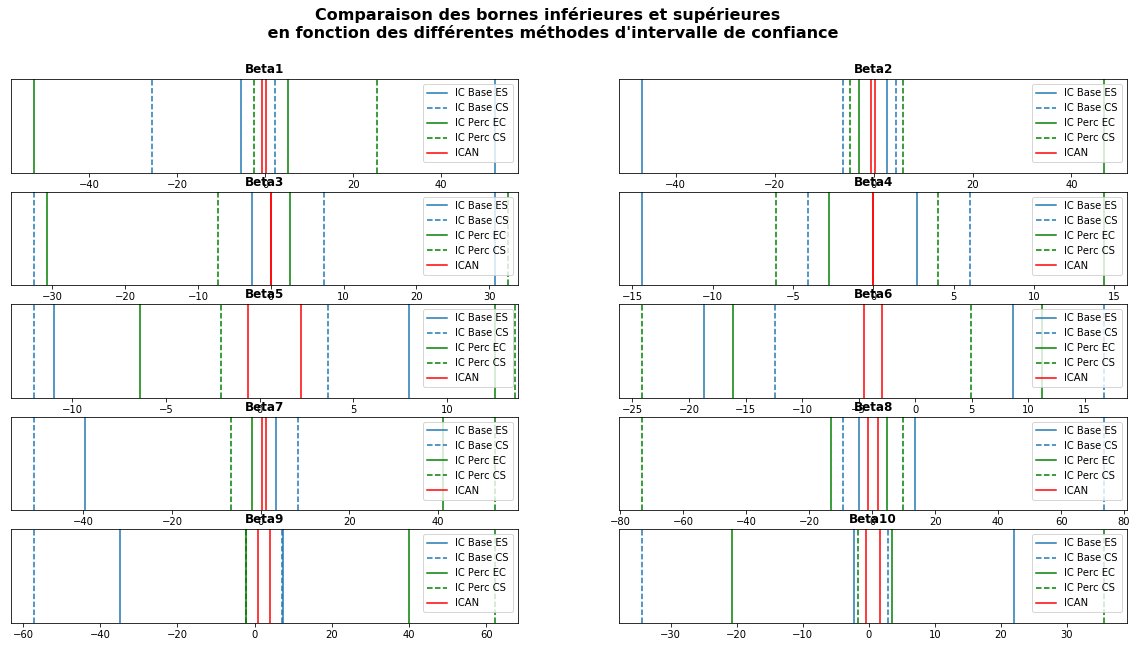

In [15]:
# A RAJOUTER: CASE SAMPLING AVEC DASH LINE
fig=plt.figure(figsize=(20,10))
plt.suptitle("Comparaison des bornes inférieures et supérieures \n en fonction des différentes méthodes d'intervalle de confiance",
            fontweight='bold',size=16)

IC_base_ES=IC_base(alpha,beta_cars,beta_ES)
IC_base_CS=IC_base(alpha,beta_cars,beta_CS)
IC_perc_ES=IC_perc(alpha,beta_cars,beta_ES)
IC_perc_CS=IC_perc(alpha,beta_cars,beta_CS)
ICAN_plot=ICAN(alpha,X_cars,y_cars,y_pred,beta_cars)

for i in range(len(beta_cars)-1):
    ax=fig.add_subplot(5,2,i+1)
    #base ES
    base_ES=ax.axvline(IC_base_ES[i-1][0] ,label="IC Base ES")
    base_ES=ax.axvline(IC_base_ES[i-1][1] ,label="IC Base ES")
    #base CS
    base_CS=ax.axvline(IC_base_CS[i-1][0] ,label="IC Base CS",linestyle='dashed')
    base_CS=ax.axvline(IC_base_CS[i-1][1] ,label="IC Base CS",linestyle='dashed')
    #percentile ES
    perc_ES=ax.axvline(IC_perc_ES[i-1][0] ,color='green',label="IC Perc EC")
    perc_ES=ax.axvline(IC_perc_ES[i-1][1] ,color='green',label="IC Perc EC")
    #percentile CS
    perc_CS=ax.axvline(IC_perc_CS[i-1][0] ,color='green',label="IC Perc CS",linestyle='dashed')
    perc_CS=ax.axvline(IC_perc_CS[i-1][1] ,color='green',label="IC Perc CS",linestyle='dashed')
    #ICAN
    ican=ax.axvline(ICAN_plot[i-1][0],color='red',label="ICAN")
    ican=ax.axvline(ICAN_plot[i-1][1],color='red',label="ICAN")
    plt.title("Beta"+str(i+1),fontweight='bold')
    plt.yticks([])
    plt.legend(handles=[base_ES,base_CS,perc_ES,perc_CS,ican])
    
plt.show()

In [33]:
def Fisher(X,X_sub,Y,gamma,beta):
    n=X.shape[0]
    p=X.shape[1]-1
    norm_h0=np.linalg.norm(Y-np.dot(X_sub,gamma))**2
    norm_h1=np.linalg.norm(Y-np.dot(X,beta))**2      
    return( (n-p)*(norm_h0-norm_h1)/norm_h1 )

In [19]:
X_sub=X_cars[:,2:]

In [22]:
lin_model_cars=sm.GLM(y_cars,X_sub)
lin_cars_res = lin_model_cars.fit()
gamma=lin_cars_res.params

In [34]:
Fisher(X_cars,X_sub,y_cars,gamma,beta_cars)

0.5937704368266743

In [45]:
def p_value(F_stat,F_obs):
    return( np.sum( [1 for b in range(len(F_stat)) if F_stat[b] > F_obs] )/len(F_stat) )

In [46]:
p_value(npr.uniform(size=10),0.5)

0.69999999999999996